# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

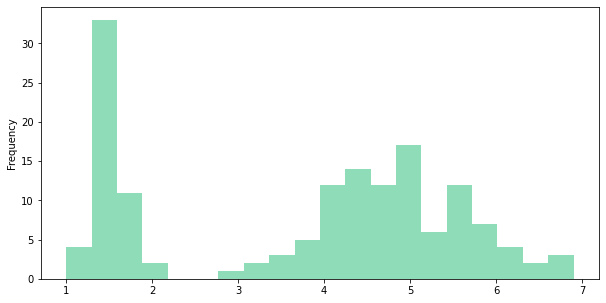

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

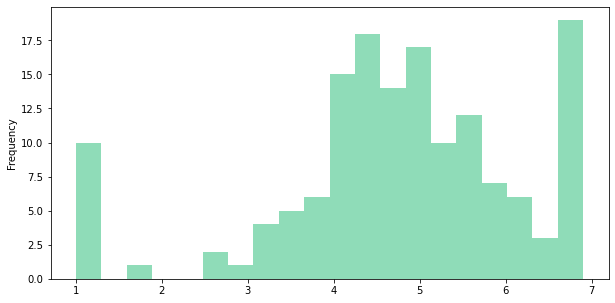

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [7]:
### снова выбросы :-(
### убираем выброс минимумов ...

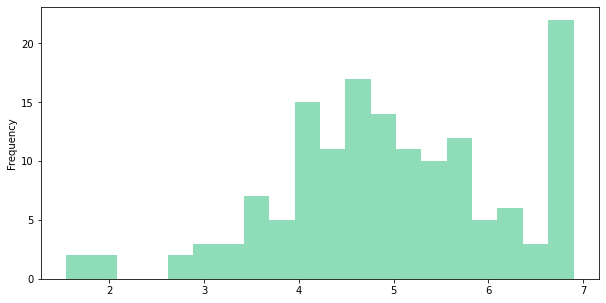

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

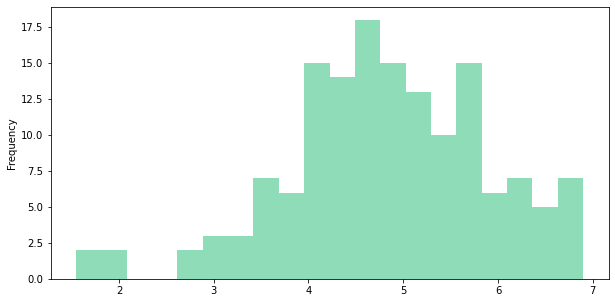

In [9]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [10]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,3.091477
1,1.4,4.537420
2,1.3,6.577441
3,1.5,2.048195
4,1.4,2.764761
5,1.7,1.545855
6,1.4,4.287929
7,1.5,4.418995
8,1.4,3.548435
9,1.5,5.770765


###### Выброс исчез

## Построение гистограмы для "petal.width"

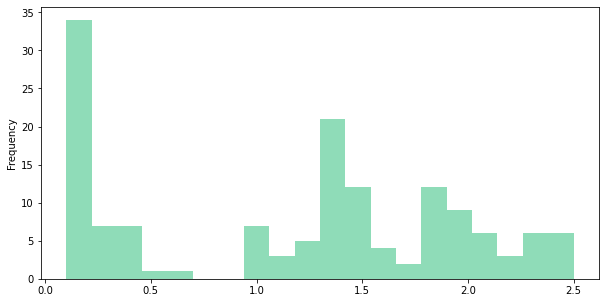

In [11]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# фиксируем значения гистограммы
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);

In [12]:
# значения столбиков гистограммы
b_before

array([34.,  7.,  7.,  1.,  1.,  0.,  0.,  7.,  3.,  5., 21., 12.,  4.,
        2., 12.,  9.,  6.,  3.,  6.,  6.])

### убеждаемся в наличии NaN

In [13]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

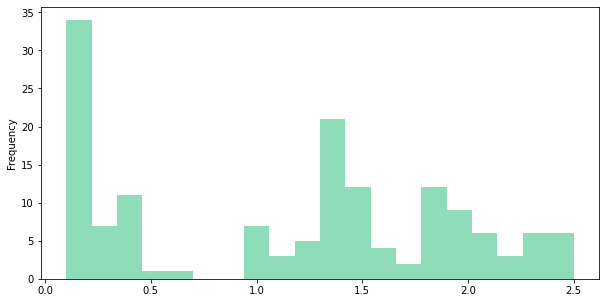

In [14]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [15]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    0.417752
146    0.417752
147    0.417752
148    0.417752
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)

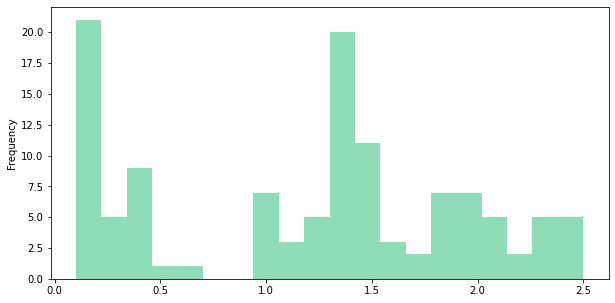

In [16]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [17]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [18]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,1.610512
1,0.590954
2,1.685516
3,1.652208
4,1.111305
...,...
145,1.046596
146,1.040169
147,0.143277
148,1.588373


In [19]:
df_corr.min() # больше нуля :-)

petal.width    0.071704
dtype: float64

### Заполняем пропуски

In [20]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,1.252735
1,0.4,0.929584
2,0.2,1.663312
3,0.2,0.834365
4,0.2,0.617463
5,0.2,1.609693
6,0.4,1.836670
7,0.1,1.488158
8,0.2,1.049943
9,0.2,1.790589


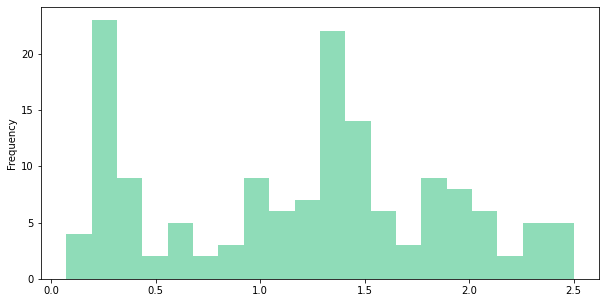

In [21]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);

In [22]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare
print ("ДО\n{} \nПОСЛЕ\n{}".format(b_before, b_after))
chisquare(b_before, b_after)

ДО
[34.  7.  7.  1.  1.  0.  0.  7.  3.  5. 21. 12.  4.  2. 12.  9.  6.  3.
  6.  6.] 
ПОСЛЕ
[ 4. 23.  9.  2.  5.  2.  3.  9.  6.  7. 22. 14.  6.  3.  9.  8.  6.  2.
  5.  5.]


Power_divergenceResult(statistic=251.14692107409496, pvalue=1.8127286597580415e-42)

### Почти похоже на исходный :-)

### Снова генерируем пропуски, но в этот раз удаляем 

In [23]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,0.417752,Virginica
148,6.2,3.4,5.4,0.417752,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [24]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,5.840215,2.300000,Virginica
119,6.0,2.2,5.000000,1.500000,Virginica
120,6.9,3.2,5.700000,2.300000,Virginica
121,5.6,2.8,4.900000,2.000000,Virginica
122,7.7,2.8,6.700000,2.000000,Virginica
123,6.3,2.7,4.900000,1.800000,Virginica
124,6.7,3.3,5.700000,2.100000,Virginica
147,6.5,3.0,5.200000,0.417752,Virginica
148,6.2,3.4,5.400000,0.417752,Virginica
149,5.9,3.0,5.100000,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [25]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,3.091477,0.2,Setosa
1,4.9,3.0,4.537420,0.2,Setosa
2,4.7,3.2,6.577441,0.2,Setosa
3,4.6,3.1,2.048195,0.2,Setosa
4,5.0,3.6,2.764761,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,2.048195,0.2,Setosa
4,5.0,3.6,2.764761,0.2,Setosa


In [26]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.485797,0.3,Setosa
1,5.012766,3.440426,4.485797,0.3,Setosa
2,5.012766,3.440426,4.485797,0.3,Setosa
3,4.600000,3.100000,2.048195,0.2,Setosa
4,5.000000,3.600000,2.764761,0.2,Setosa


## Extra case. Infinity

In [27]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,4.189749,inf,Setosa
16,5.4,3.9,3.972570,-inf,Setosa
17,5.1,3.5,1.561626,inf,Setosa
18,5.7,3.8,5.191922,-inf,Setosa


### Гистограмма не строится при наличии inf

In [28]:
data["petal.width"].describe()

count    128.000000
mean            NaN
std             NaN
min            -inf
25%        0.479438
50%        1.300000
75%        1.630000
max             inf
Name: petal.width, dtype: float64

In [29]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [30]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,3.547028,0.2,Setosa
15,5.7,4.4,4.189749,NaN,Setosa
16,5.4,3.9,3.972570,NaN,Setosa
17,5.1,3.5,1.561626,NaN,Setosa
18,5.7,3.8,5.191922,NaN,Setosa
19,5.1,3.8,6.900000,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

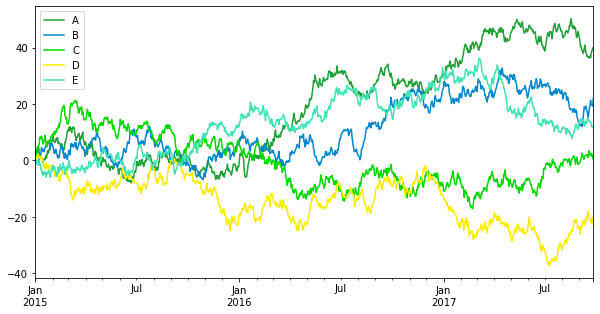

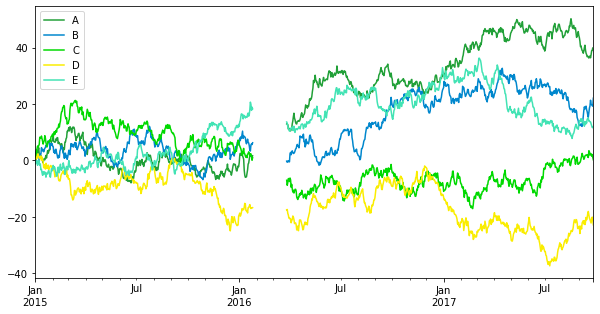

In [31]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

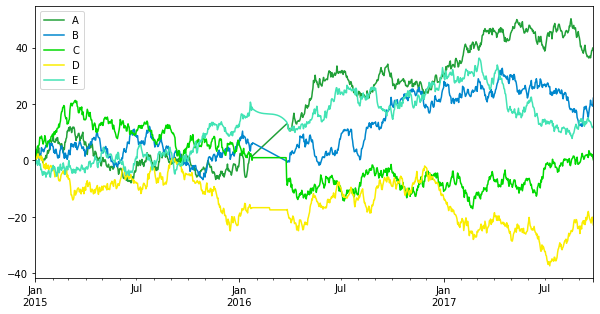

In [32]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [33]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject       Before                                            Recycled  \
type               A         B         C          D          E         A   
2016-02-05  0.587070  5.531027  5.312444 -20.706140  17.527037  3.663123   
2016-02-06  0.711320  4.761468  4.743962 -20.744121  16.892030  3.848723   
2016-02-07  1.193084  3.793440  3.209615 -19.820555  16.200795  4.034322   
2016-02-08  2.570147  4.070351  1.061032 -21.728561  16.246578  4.219922   
2016-02-09  2.825205  3.458310  2.130647 -20.486354  16.813684  4.405522   
2016-02-10  3.483313  5.004614  0.406963 -19.355824  17.303744  4.591122   
2016-02-11  4.297125  4.461385  1.065935 -17.646871  16.685282  4.776721   
2016-02-12  5.015147  3.256945  2.389380 -17.172022  18.760280  4.962321   
2016-02-13  3.421695  3.025560  0.995349 -16.862890  19.416210  5.147921   
2016-02-14  3.240069  5.400901  0.342601 -16.459333  18.267042  5.333521   
2016-02-15  3.406852  5.551033  1.183051 -15.473694  16.968661  5.519121   
2016-02-16  3.490674  5.997467 -1.137773 -15.050324  15.890260  5.704720   
2016-02-17  4.199654  3.477039 -0.815430 -14.535329  14.049385  5.890320   
2016-02-18  4.752925  3.987715 -1.231169 -14.516198  16.198941  6.075920   
2016-02-19  5.443006  3.925301 -0.287157 -13.805213  17.834409  6.261520   
2016-02-20  7.575313  4.441676  0.304158 -12.550687  16.569098  6.447119   
2016-02-21  6.703913  4.011284 -1.164636 -12.584228  16.713211  6.632719   
2016-02-22  5.947995  3.595473 -0.288581 -13.313951  15.694494  6.818319   
2016-02-23  4.406608  3.145468  1.376846 -14.157020  15.131795  7.003919   
2016-02-24  5.153518  4.021937  0.004313 -14.192822  14.784286  7.189519   

subject                                               
type               B         C          D          E  
2016-02-05  5.062292  0.954433 -16.773215  17.006429  
2016-02-06  4.955445  0.954433 -16.773215  16.940046  
2016-02-07  4.848599  0.954433 -16.773215  16.880209  
2016-02-08  4.741753  0.954433 -16.773215  16.826505  
2016-02-09  4.634907  0.954433 -16.773215  16.778520  
2016-02-10  4.528061  0.954433 -16.773215  16.735841  
2016-02-11  4.421215  0.954433 -16.773215  16.698054  
2016-02-12  4.314369  0.954433 -16.773215  16.664746  
2016-02-13  4.207522  0.954433 -16.773215  16.635503  
2016-02-14  4.100676  0.954433 -16.773215  16.609913  
2016-02-15  3.993830  0.954433 -16.773215  16.587561  
2016-02-16  3.886984  0.954433 -16.773215  16.568035  
2016-02-17  3.780138  0.954433 -16.773215  16.550919  
2016-02-18  3.673292  0.954433 -16.773215  16.535803  
2016-02-19  3.566446  0.954433 -16.773215  16.522271  
2016-02-20  3.459600  0.954433 -16.773215  16.509910  
2016-02-21  3.352753  0.954433 -16.773215  16.498307  
2016-02-22  3.245907  0.954433 -16.773215  16.487048  
2016-02-23  3.139061  0.954433 -16.773215  16.475721  
2016-02-24  3.032215  0.954433 -16.773215  16.463911

In [34]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [35]:
type(accurancy)

pandas.io.formats.style.Styler

In [36]:
accurancy.to_excel("accurancy.xlsx") # xlsx only